 Training and Test Sets

This notebook is an adaptation of the [original by *Aurélien Gerón*](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb), from his book: [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition. Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)

In [1]:
import pandas as pd
housing = pd.read_csv("./data/housing.csv")

Normally, a portion of the data is separated to be used as a test set (***test set***), and the model is trained with the rest (***train set***). This is to avoid **overfitting**, which occurs when the model fits too closely to the training data and doesn't generalize well to new data. If the error on the training set is low and on the test set is high, the model is overfitted.

It's common to use 20% of the data for the test set, but this depends on the dataset size. The larger the dataset, the less data we'll need for the test set.
<!-- TODO: In the original it forces the random seed -->

# Random sampling with NumPy

In [ ]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    ''' Shuffles the data and divides it into train (training) and test according to the specified ratio. 
    
        Parameters
        ----------
        data: pandas.DataFrame
            Dataframe containing the data you want to split
        test_ratio: float
            Proportion (between 0 and 1) of data to be used for test (the rest will be used for training)
    
        Returns
        -------
        train_set: pandas.DataFrame
            Dataframe with the training data
        test_set: pandas.DataFrame
            Dataframe with the test data
    '''
    shuffled_indices = np.random.permutation(len(data)) # Generate indices randomly
    test_set_size = int(len(data) * test_ratio) # Calculate the number of samples that will go to the test set
    test_indices = shuffled_indices[:test_set_size] # Select indices for the test set
    train_indices = shuffled_indices[test_set_size:] # Select indices for the training set
    return data.iloc[train_indices], data.iloc[test_indices] # Return the train and test sets

In [ ]:
train_set, test_set = shuffle_and_split_data(housing, 0.2) # generate train and test sets (20% for test)
len(train_set), len(test_set)

# Random sampling with scikit-learn

The same can be done directly using scikit-learn's `train_test_split` function:

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(train_set), len(test_set)

(16512, 4128)

Additionally, in this example the `random_state` argument is also passed to make the result reproducible.

We must remember that computers generate pseudorandom numbers from a [random seed](https://es.wikipedia.org/wiki/Semilla_aleatoria) that normally varies with each execution (this is precisely how randomness is achieved), typically one of the most used is the system time in milliseconds at the moment of execution. Therefore, if the seed is not fixed, each time the code is executed a different result will be obtained.

This parameter (`random_state`) allows fixing the random seed with any number so that the results are reproducible. This is useful for comparing different models, debugging errors or sharing results.

This method allows recovering the input data and labels separately, which is useful for training scikit-learn models. Instead of passing the dataset directly, first the data set is passed (in this case all columns except `median_house_value`) and then the labels (the `median_house_value` column).

In [ ]:
train, test, train_labels, test_labels = train_test_split(
    housing.drop(columns="median_house_value"), # Input data (all except the label)
    housing["median_house_value"], # Labels
    test_size=0.2,
    random_state=42)

In this way we would already have separately the test group with its input data and labels, and the training group with its input data and labels.

[
![train_test](img/x-y_train_test.jpg)
](https://builtin.com/data-science/train-test-split)

# Stratified sampling

The previous separation was done randomly. This is usually correct with a sufficiently large *dataset*, but if it isn't, there's a risk of introducing **sampling bias**, since it could be that our test group, for example, doesn't contain enough examples from a specific part of the distribution.

Let's suppose another case: when conducting a survey on opinions of the population of Spain, since we cannot consult the entire population, a **sample group** of 1000 people is selected. If only chance is used, we might find that almost all respondents are men. This wouldn't be a problem if we can assume that men and women have homogeneous opinions, but if not, we would be biasing our study by considering that the majority opinions among men are the majority among the total population. In many cases it will be the same to take into account aspects such as age, income, education level, locality, etc.

This is called **sampling bias**. To avoid it, **[stratified sampling](https://es.wikipedia.org/wiki/Muestreo_estratificado)** can be performed by dividing the *dataset* into groups called **strata**, and ensuring to take not only a percentage of samples from the total, but that percentage from each stratum.

In the problem we are addressing, we can expect that median income is a particularly important predictor variable (later we will see that it best correlates with the output<!-- TODO: wouldn't it make more sense to put all EDA before testing? -->). Since this attribute is continuous numeric, we will need to **discretize** it to create a new income category attribute where each category represents a stratum. That way we can sample each stratum, keeping their sizes proportional in the training and test sets.
<!-- TODO: isn't stratifying by target better? more prone to overfitting? -->

If we look again at the `median_income` histogram, we see that most values are between 1.5 and 6, but some go up to 15. It's important to have a sufficient number of instances in each stratum, so we shouldn't have too many strata, and each should be large enough.

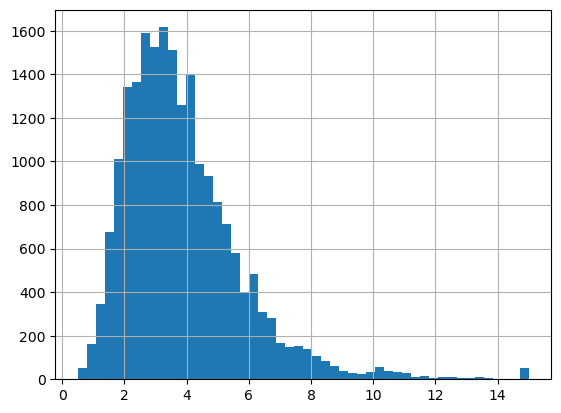

In [6]:
_ = housing["median_income"].hist(bins=50)

Pandas' `pd.cut` function allows us to create a new column segmenting into categories. In this case, we're going to create 5 categories, separating into blocks of 1.5 (except the last one which will group the entire thick tail on the right), and we're going to use the `value_counts` function to see how many values are in each category.

In [7]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf], # Secuencia de límites de los contenedores
                               labels=[1, 2, 3, 4, 5])

In [ ]:
import matplotlib.pyplot as plt

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of records")
plt.show()

We can use scikit-learn's `train_test_split` function again, but this time with the `stratify` parameter indicating the column we want to use to stratify the sampling.

In [9]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"],random_state=42)

It is observed that the test set generated using stratified sampling has a much more representative amount of samples in each stratum of the total population, despite being random.

In [10]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

Now we can show a complete dataframe with the random and stratified sampling errors, and see that the stratified sampling error is much smaller.

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data) # proportion of values in each income_cat

train_set, test_set = train_test_split(housing, test_size=0.2) # re-executing this cell we can see the variation in random split

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing), # proportion of values in each income_cat in the original dataset
    "Stratified %": income_cat_proportions(strat_test_set), # proportion in the stratified test set
    "Random %": income_cat_proportions(test_set), # proportion in the randomly generated test set
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"] - 1) # stratified error with respect to original
compare_props["Rand. Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1) # random error with respect to original
(compare_props * 100).round(2) # convert all values to percentage with two decimals

Since we will no longer need the `income_cat` variable (it was only used as a help for stratifying), we can remove it from both generated sets.

In [12]:
strat_train_set.drop("income_cat", axis=1, inplace=True)
strat_test_set.drop("income_cat", axis=1, inplace=True)

strat_train_set.head().T

,12655,15502,2908,14053,20496
longitude,-121.46,-117.23,-119.04,-117.13,-118.7
latitude,38.52,33.09,35.37,32.75,34.28
housing_median_age,29.0,7.0,44.0,24.0,27.0
total_rooms,3873.0,5320.0,1618.0,1877.0,3536.0
total_bedrooms,797.0,855.0,310.0,519.0,646.0
population,2237.0,2015.0,667.0,898.0,1837.0
households,706.0,768.0,300.0,483.0,580.0
median_income,2.1736,6.3373,2.875,2.2264,4.4964
median_house_value,72100.0,279600.0,82700.0,112500.0,238300.0
ocean_proximity,INLAND,NEAR OCEAN,INLAND,NEAR OCEAN,<1H OCEAN
